In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

import tidalsim.modeling.extrapolation as tme
from tidalsim.util.pickle import load

import importlib
importlib.reload(tme)

def make_arrays_equal_size(arr1, arr2):
    if len(arr1) > len(arr2):
        return arr1[:len(arr2)], arr2
    else:
        return arr1, arr2[:len(arr1)]

In [23]:
def get_run_dir(binary: str) -> Path:
    return Path.cwd().parent / "runs" / binary

interval_length = 1000
clusters = 14
# run_dir = get_run_dir("aha-mont64-fb8c96bc")
# run_dir = get_run_dir("crc32-5a0c5b8b")
run_dir = get_run_dir("huffbench-c613d0e8")
estimated_perf, true_perf = tme.analyze_tidalsim_results(run_dir, interval_length, clusters, detailed_warmup_insts=0, elf=False, interpolate_clusters=False)
if true_perf is None:
    print("Golden performance results not available")

In [24]:
if true_perf is not None:
    y_true, y_pred = make_arrays_equal_size(true_perf.ipc, estimated_perf.est_ipc)
    ipc_mape = mean_absolute_percentage_error(y_true, y_pred)
    print(ipc_mape)


0.13847604999521942
0.13847604999521942


In [25]:
estimated_perf['z_dist_to_centroid'] = estimated_perf.groupby('cluster_id')['dist_to_centroid'].transform(lambda x: np.abs(scale(x)))

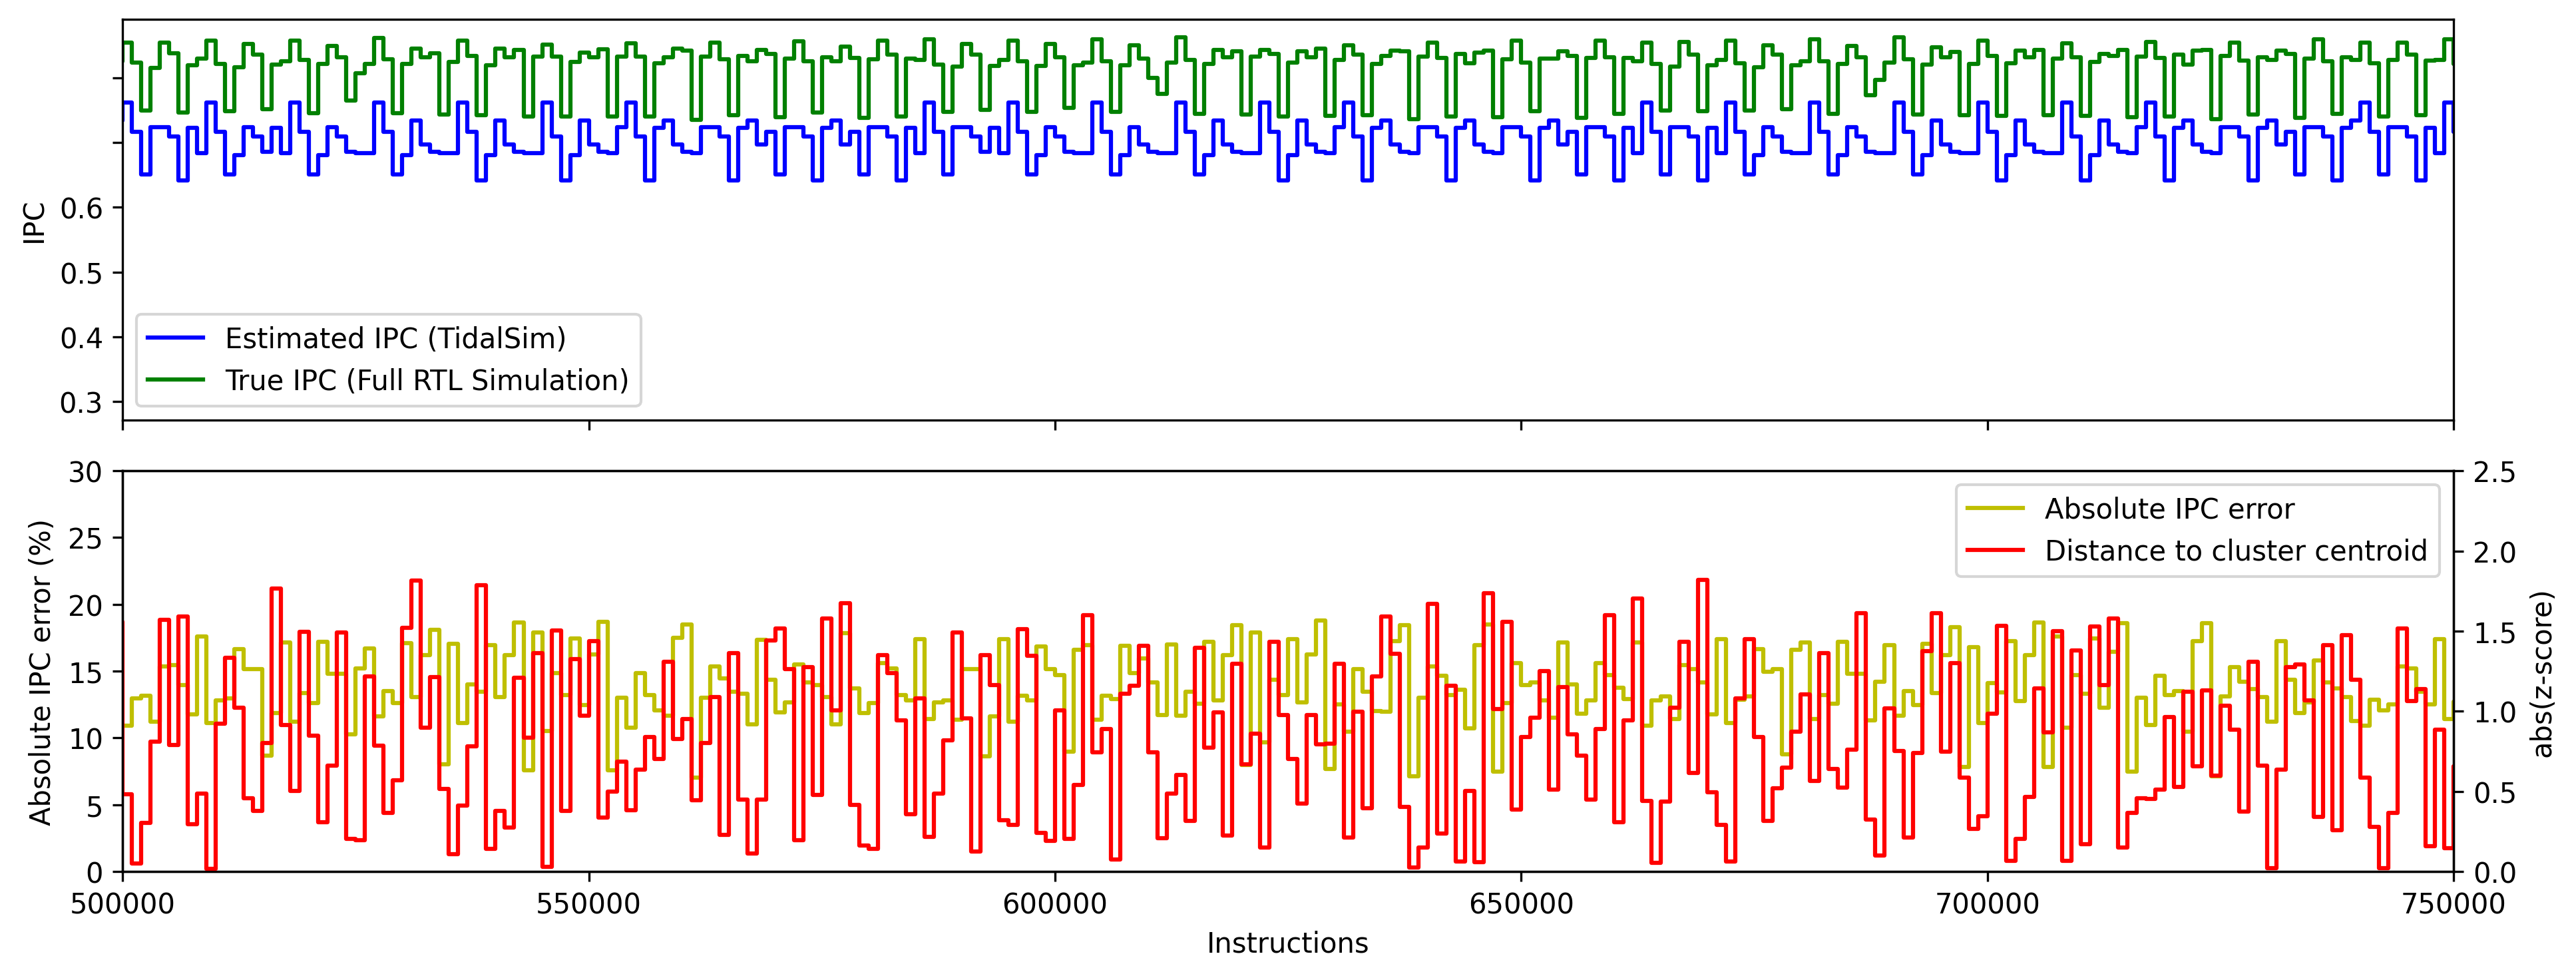

In [26]:
# https://stackoverflow.com/questions/37737538/merge-subplots-with-shared-x-axis
# https://matplotlib.org/stable/gallery/spines/multiple_yaxis_with_spines.html

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw=dict(height_ratios=[1,1]))
ax3 = ax2.twinx()

p1, = ax1.step(estimated_perf.inst_count, estimated_perf.est_ipc, "b", label="Estimated IPC (TidalSim)")
if true_perf is not None:
    p2, = ax1.step(true_perf.inst_count, true_perf.ipc, "g", label="True IPC (Full RTL Simulation)")
    p3, = ax2.step(true_perf.inst_count, np.multiply(ipc_abs_error_trace, 100), 'y', label="Absolute IPC error")
p4, = ax3.step(estimated_perf.inst_count, estimated_perf['z_dist_to_centroid'], 'r', label='Distance to cluster centroid')
ax1.set_xlim([0.5e6, 0.75e6])
#ax1.set_ylim([0.65, 0.9])
ax2.set_ylim([0, 30])
ax3.set_ylim([0, 2.5])
ax2.set_xlabel('Instructions')
ax1.set_ylabel('IPC')
ax2.set_ylabel('Absolute IPC error (%)')
ax3.set_ylabel('abs(z-score)')
ax1.legend()
ax2.legend(handles=[p3, p4] if true_perf is not None else [p4])
# remove top-most tick label for the first subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)
fig.set_size_inches(13, 5)
plt.tight_layout()
plt.savefig('huffbench_results.svg')

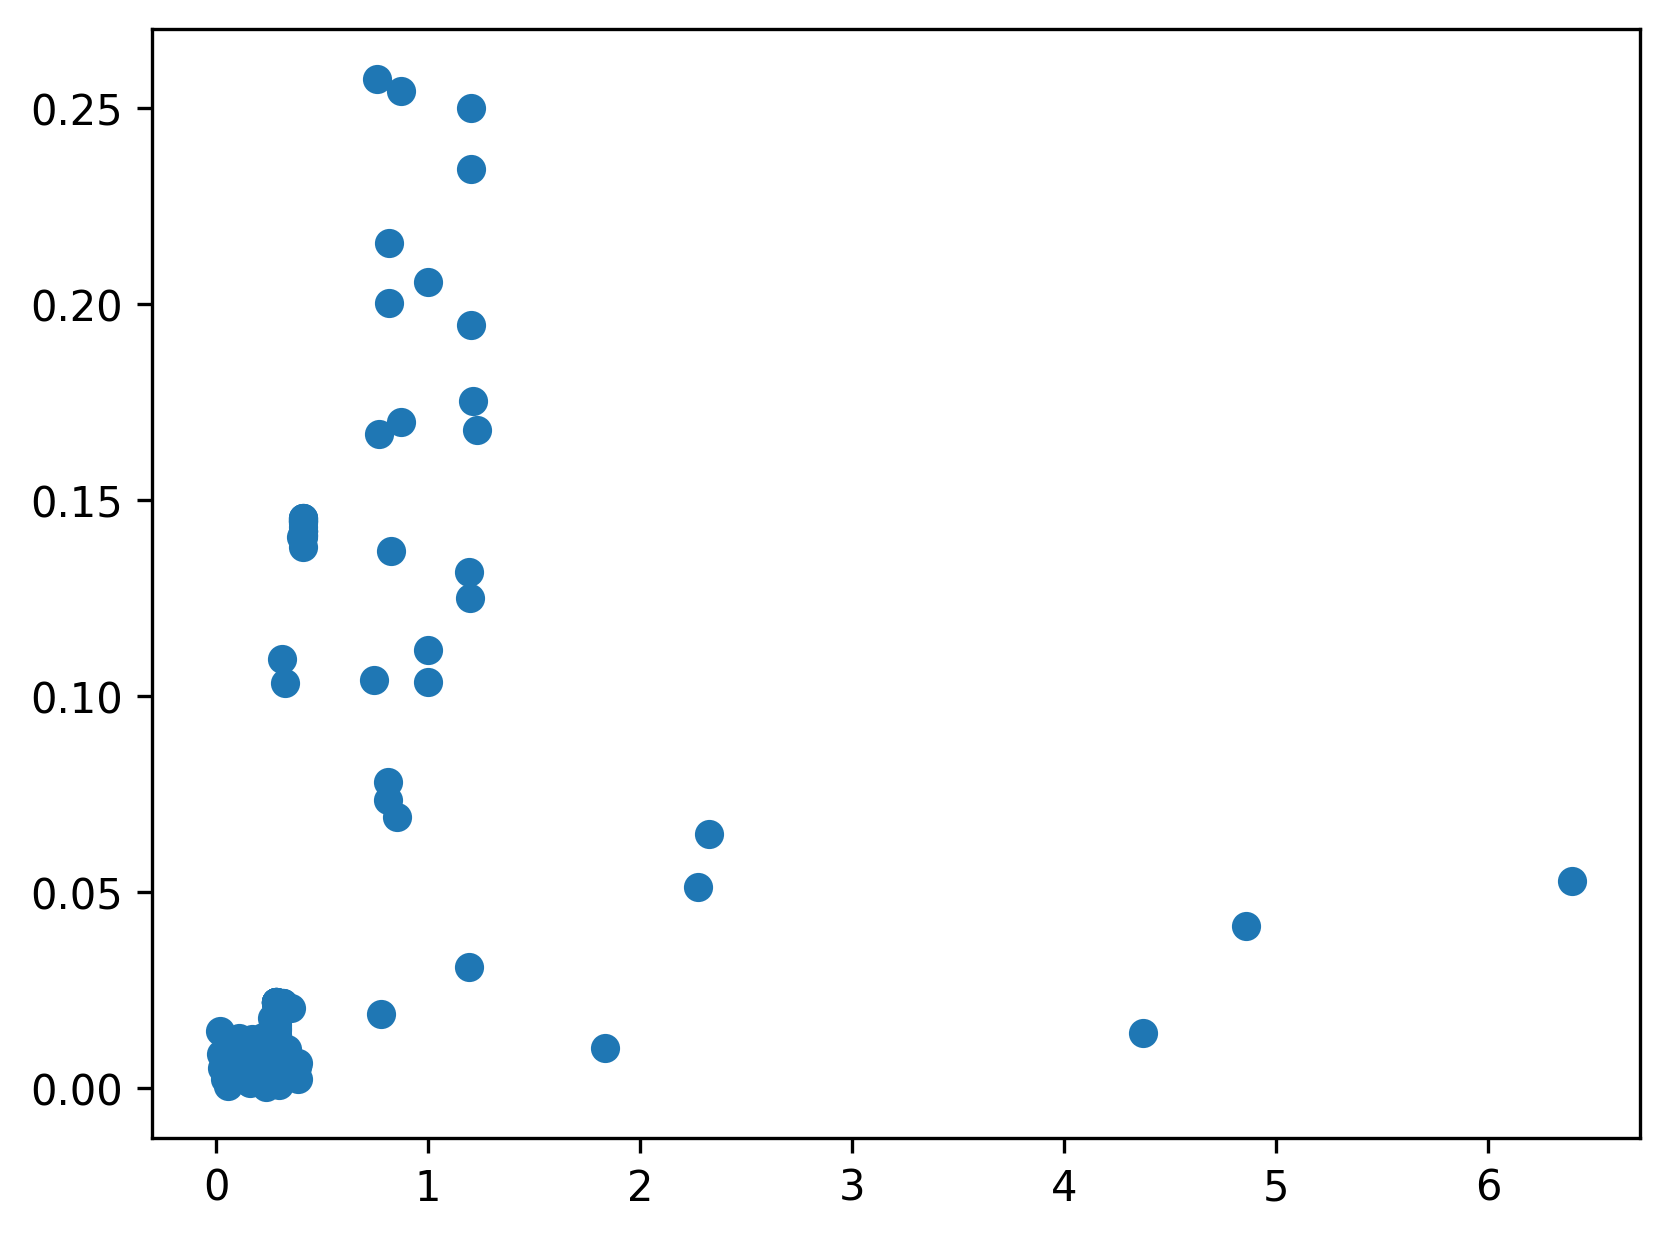

In [6]:
plt.scatter(estimated_perf['z_dist_to_centroid'][:len(ipc_abs_error_trace)][100:-100], ipc_abs_error_trace[100:-100])

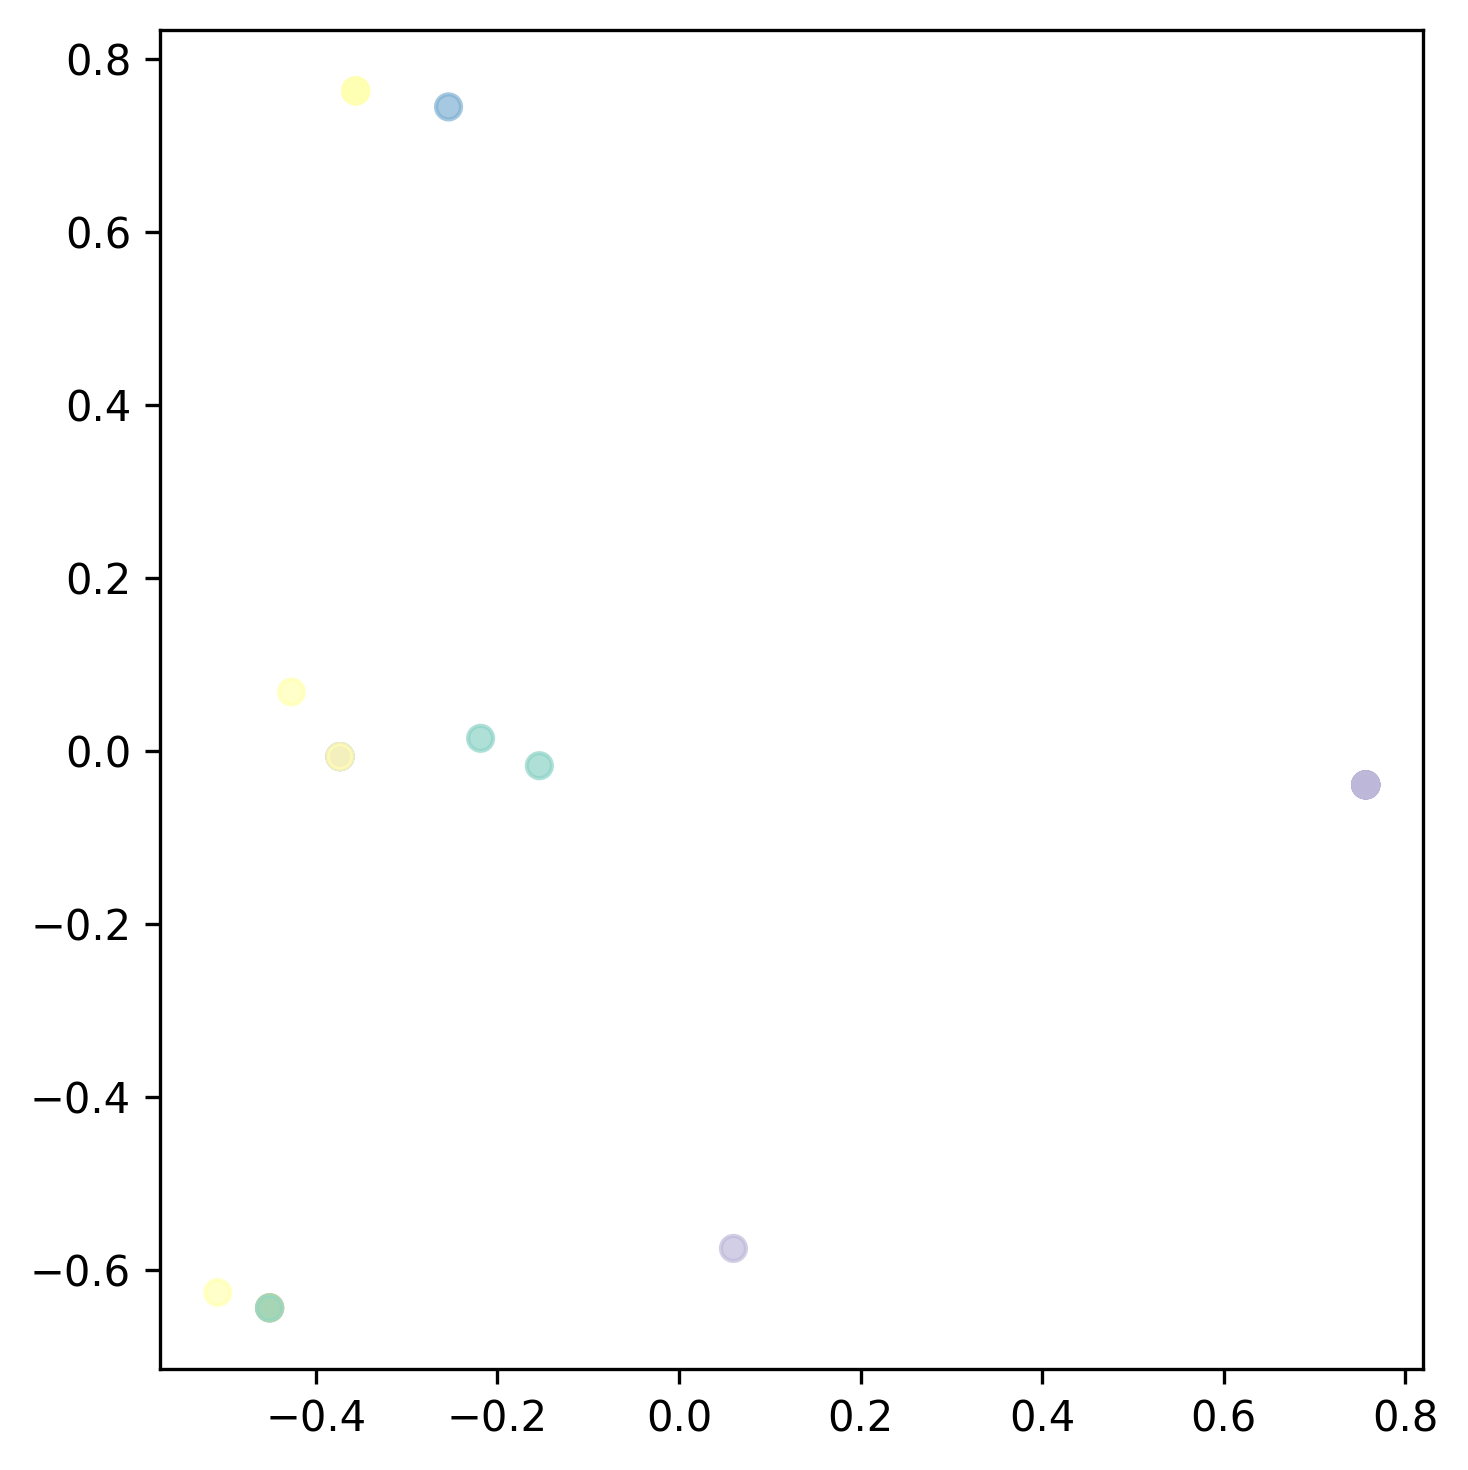

In [9]:
pca = PCA(n_components=2)
matrix = np.vstack(estimated_perf['embedding'][100:-100])
embedding_reduced = pd.DataFrame(pca.fit_transform(matrix), columns=['PC1', 'PC2'])
embedding_reduced['color'] = estimated_perf['cluster_id'][100:-100]
fig, ax = plt.subplots()
scatter = ax.scatter(embedding_reduced['PC1'], embedding_reduced['PC2'], c=embedding_reduced['color'], cmap='Set3', alpha=0.7)
#legend = ax.legend(*scatter.legend_elements())
#ax.add_artist(legend)
fig.set_size_inches(5, 5)
plt.tight_layout()

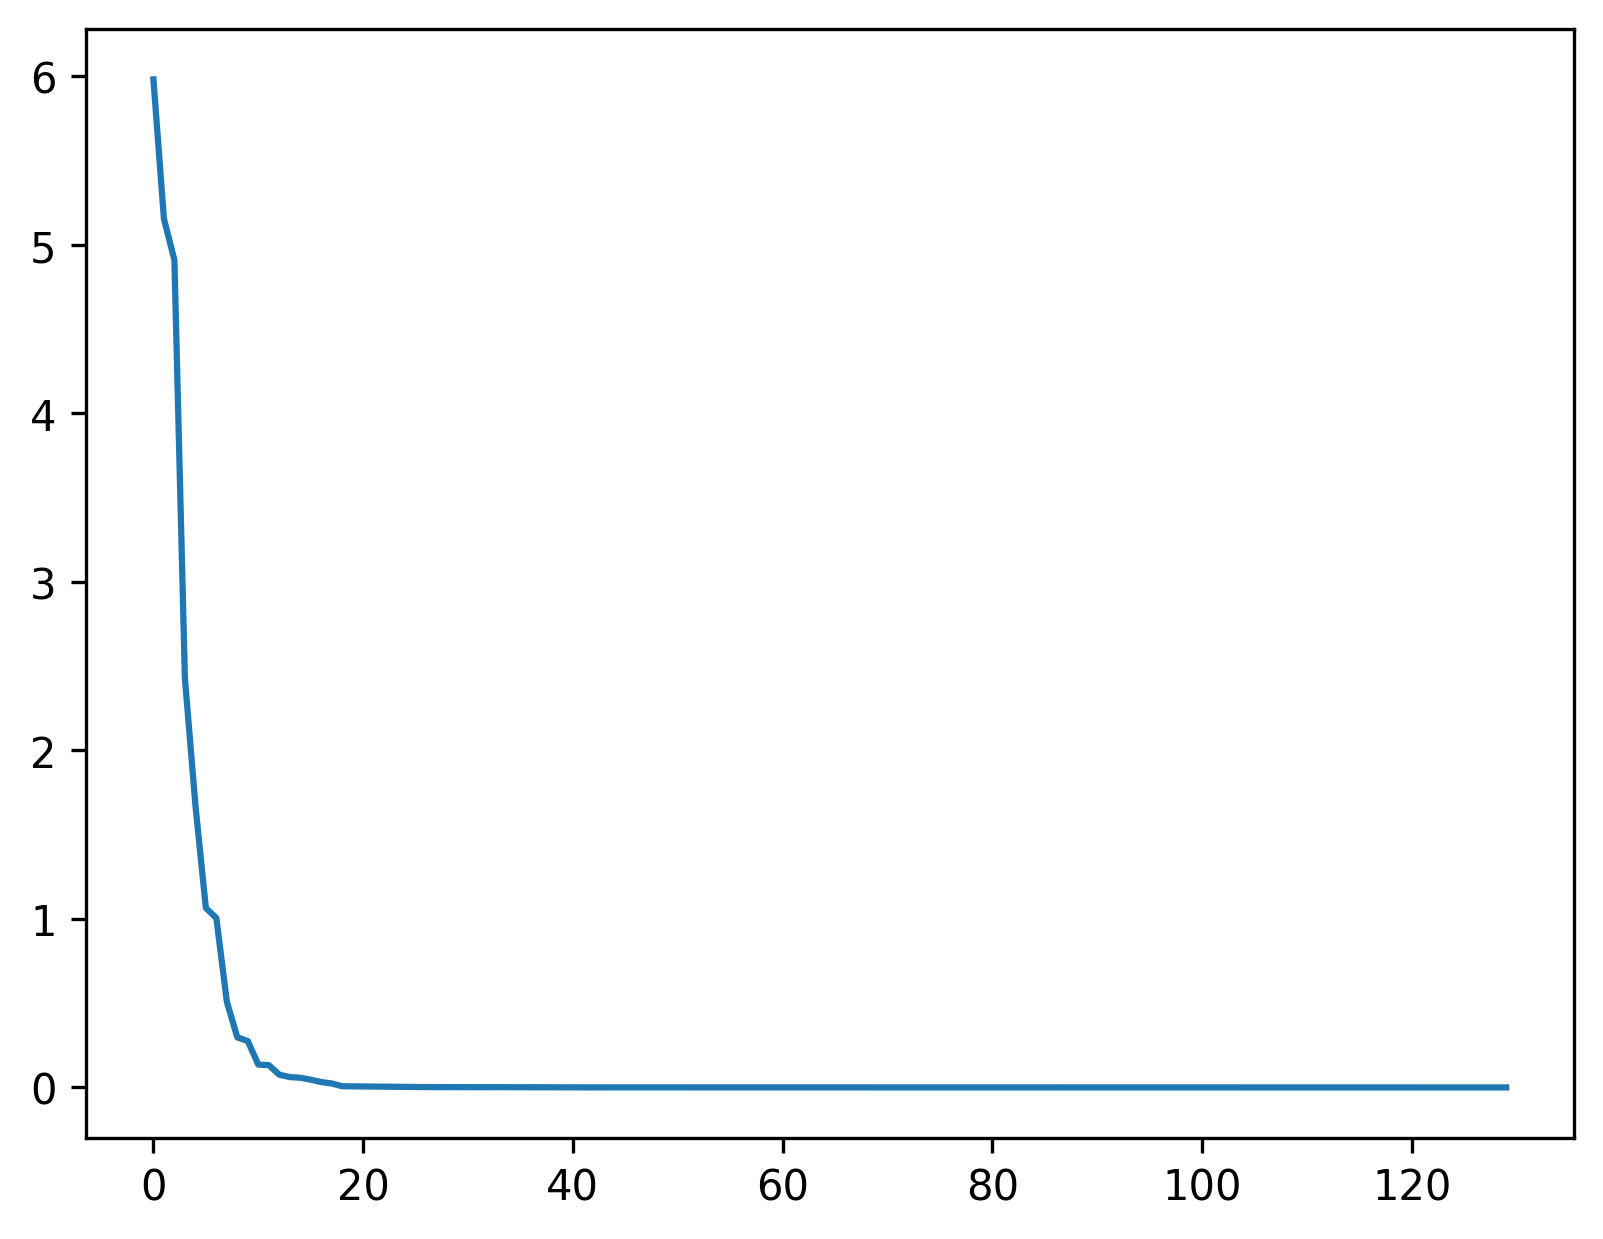

In [10]:
pca_full = PCA()
pca_full.fit(matrix)
plt.plot(pca_full.singular_values_)

/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:379: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:379: RuntimeWarning: invalid value encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: invalid value encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


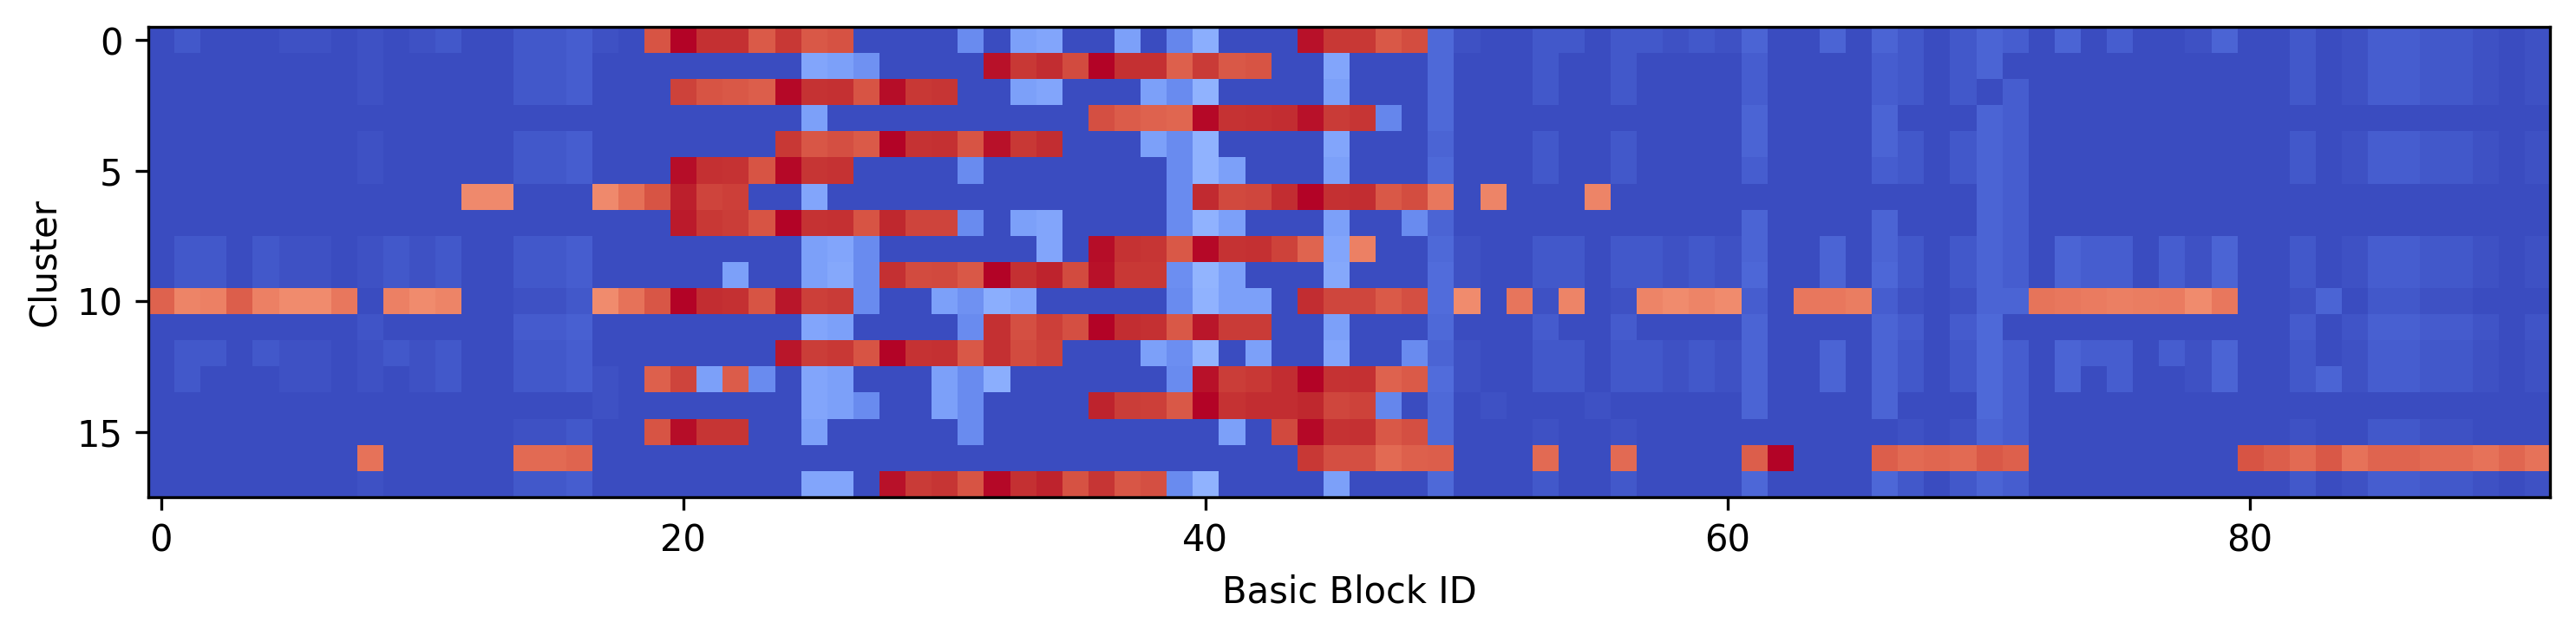

In [9]:
kmeans = load(Path('/scratch/vighneshiyer/chipyard/tools/tidalsim/runs/aha-mont64-fb8c96bc/n_1000_spike/c_18/kmeans_model.pickle'))
centers = np.apply_along_axis(np.log, 1, kmeans.cluster_centers_)
fig, ax = plt.subplots()

import matplotlib as mpl
cmap = mpl.colormaps.get_cmap('coolwarm')
cmap.set_bad(color=cmap(0))

cmap = ax.imshow(centers, cmap=cmap, interpolation='nearest')
ax.set_xlabel('Basic Block ID')
ax.set_ylabel('Cluster')
plt.subplots_adjust(hspace=.0)
fig.set_size_inches(10, 3)
plt.tight_layout()
plt.savefig('aha-mont64_clustering.svg', bbox_inches='tight')